# Clear all 

In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Importing Modules 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [4]:
import pickle
import scipy.io as sio
from basicFunctions.filters import \
                        butter_bandpass_filter,butter_highpass_filter,butter_lowpass_filter
from scipy import signal
from matplotlib.backends.backend_pdf import PdfPages

In [32]:
%load_ext autoreload
%autoreload 2

In [6]:
from intanRead.IntanRaw_read_data import IntanRaw_read_data

from mainFunctions.loadDataFilePath import loadDataFilePath
from mainFunctions.readDigitalChannels import readDigitalChannels
from mainFunctions.readAnalogChannels import readAnalogChannels
from mainFunctions.stimOnsetExtraction import stimOnsetExtraction
from mainFunctions.loadSpikesFromPhy import loadSpikesFromPhy
from mainFunctions.neuronsInfoExtraction import neuronsInfoExtraction
from mainFunctions.pupilSizeReading import pupilSizeReading
from mainFunctions.spikeTriggeredAvgPupilSize import spikeTriggeredAvgPupilSize
from mainFunctions.neuronVisualResponse import neuronVisualResponse
from mainFunctions.tuningCurveAndOSI import tuningCurveAndOSI
from mainFunctions.extractLowAndHighArousalTrials import extractLowAndHighArousalTrials
from mainFunctions.allTrialsResponses import allTrialsResponses
from mainFunctions.responseChangeByAlertness import responseChangeByAlertness
from mainFunctions.bestOrienationResponseChangeByAlertness\
                    import bestOrienationResponseChangeByAlertness
from mainFunctions.noiseCorrBetweenAlertAndNonAlertTrials\
                    import noiseCorrBetweenAlertAndNonAlertTrials
from mainFunctions.powerSpectrumSingleChannel import powerSpectrumSingleChannel
from mainFunctions.estimatedL5chnnael import estimatedL5chnnael
from mainFunctions.exctractAlertAndNonAlertPeriods\
                    import exctractAlertAndNonAlertPeriods
from mainFunctions.spectrumCompareAlertNonAlert\
                    import spectrumCompareAlertNonAlert

darkMode = True

## Getting the data file

#### select the reordered high-pass filtered file

In [7]:
dataFileAdd, dataFileBaseFolder, infoFileAdd = loadDataFilePath\
                            ("Y:\Ehsan-temp\Claire-Ehsan_Share")

## Reading the info file

In [8]:
infoResult = IntanRaw_read_data(infoFileAdd)
channelsNo = len(infoResult['amplifier_channels'])
ADC_channelsNo = len(infoResult['board_adc_channels'])
fs = int(infoResult['frequency_parameters']['board_dig_in_sample_rate'])


Reading Intan Technologies RHD2000 Data File, Version 1.5

Found 64 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 6 board ADC channels.
Found 16 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

Header file contains no data.  Amplifiers were sampled at 20.00 kS/s.
Done!  Elapsed time: 0.1 seconds


### Reading the digital data file

In [9]:
stimID, firstBeforeStimTagSampleNo = readDigitalChannels(dataFileBaseFolder)

### Reading the analog data file to extract raw photoDiodeSignal and raw camerastrob

In [10]:
photoDiodeSignal, cameraStrobe = readAnalogChannels(dataFileBaseFolder,ADC_channelsNo)

### pupil size and camera strobe extraction

154832 :Number of strobe signals
154832 :Number of saved frames
these two numbers should be the same


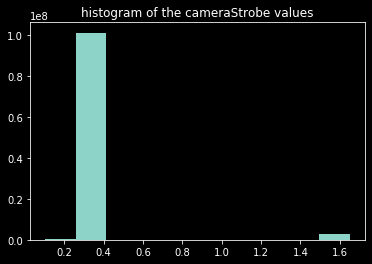

In [11]:
framesStartSample, pupilSmoothArea, pupilArea, firstCapturedFrame_Sample, lastCapturedFrame_Sample = \
                                    pupilSizeReading(cameraStrobe,dataFileBaseFolder,darkMode = darkMode)

### stimOnset based on the photoDiode Signal

960 : this should be equal to totalTrialNo in the matlab stim presentation m-file (load the workspace in matlab)


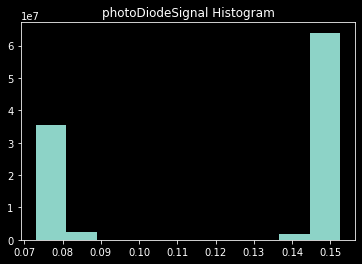

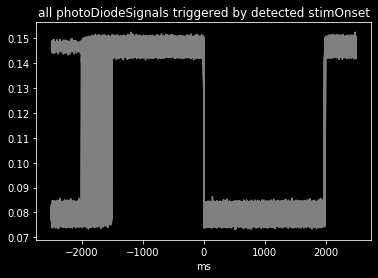

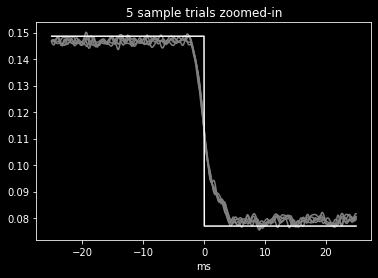

In [12]:
stimOnsetSample = stimOnsetExtraction(photoDiodeSignal,firstBeforeStimTagSampleNo,fs)

## loading the sorting results from KiloSort-Phy

#### Ctl+s in Phy first!

In [13]:
spikeTime, spikeClusters, SUA_clusters, MUA_clusters = loadSpikesFromPhy(dataFileBaseFolder)

[  7  65 283 285 286] these clusters numbers should be the same as the ones that have been asigned as good units in Phy


## Extracting the spike wave-shapes, spont FRs and the channels

In [33]:
firstCapturedFrame_Sample

207027

In [34]:
firstBeforeStimTagSampleNo

30380589

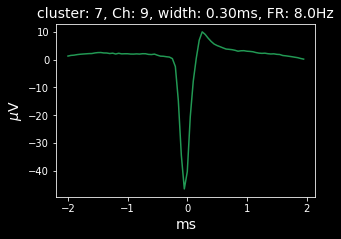

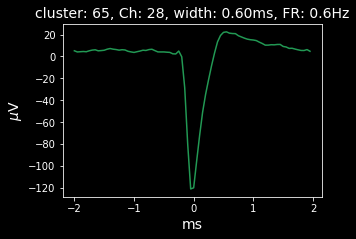

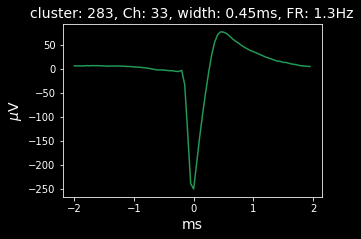

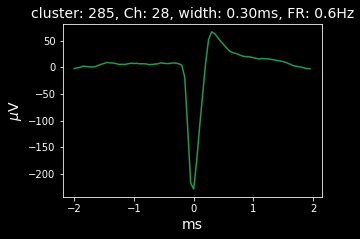

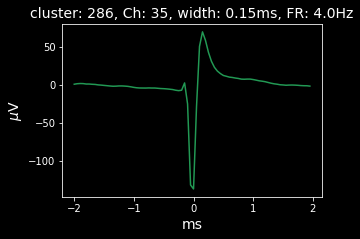

In [46]:
spontFRs, spikeWidthAll, clusterChannel, spikeShapesFiltered, spikeClustersToPlot, recordingDurInMS = \
    neuronsInfoExtraction(dataFileAdd, spikeTime, spikeClusters, SUA_clusters, MUA_clusters, firstBeforeStimTagSampleNo,\
                          firstCapturedFrame_Sample, fs, spikeTypes = 'SUA')

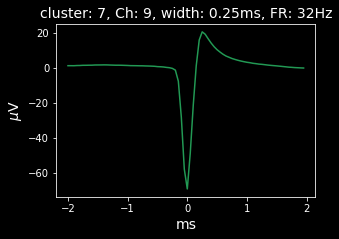

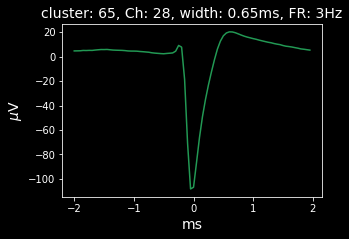

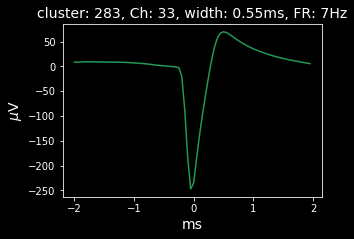

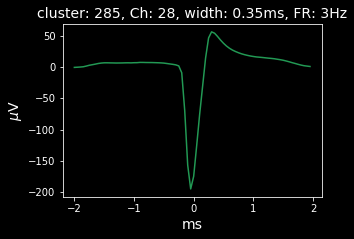

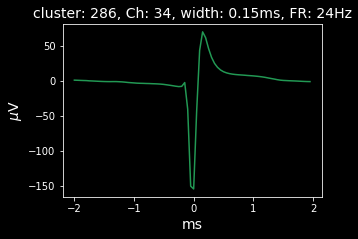

In [14]:
spontFRs, spikeWidthAll, clusterChannel, spikeShapesFiltered, spikeClustersToPlot, recordingDurInMS = \
    neuronsInfoExtraction(dataFileAdd, spikeTime, spikeClusters, SUA_clusters, MUA_clusters, firstBeforeStimTagSampleNo,\
                          firstCapturedFrame_Sample, fs, spikeTypes = 'SUA')

### spike-triggered Average of pupil size

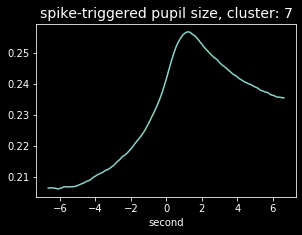

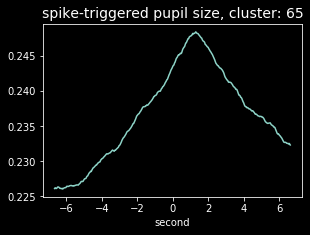

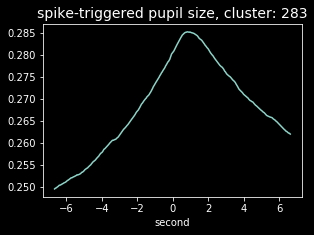

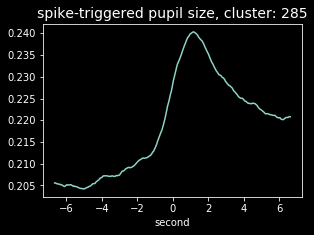

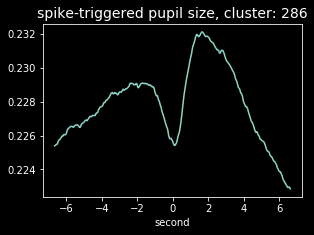

In [15]:
allSpikeTriggeredPupil = spikeTriggeredAvgPupilSize(framesStartSample,\
                                 pupilSmoothArea, spikeClustersToPlot, spikeTime, spikeClusters,\
                                                   lastCapturedFrame_Sample)

### visual responsiveness of neurons

D:\WorkSpaces\ClaireRenataGrantFeb2020\mainFunctions\neuronVisualResponse.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figPSTH = plt.figure(figsize=(6,8))#plt.figure(figsize=(0.3*responseWindowDur/(20e-3),0.15*len(validChannelsRange)/3))
D:\WorkSpaces\ClaireRenataGrantFeb2020\mainFunctions\neuronVisualResponse.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figPSTH = plt.figure(figsize=(6,8))#plt.figure(figsize=(0.3*responseWindowDur/(20e-3),0.15*len(validChannelsRange)/3))
D:\WorkSpaces\ClaireRenataGrantFeb2020\mainFunctions\neuro

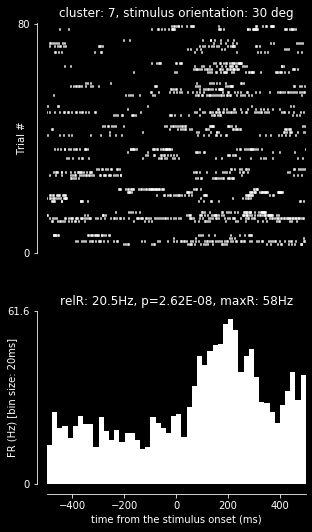

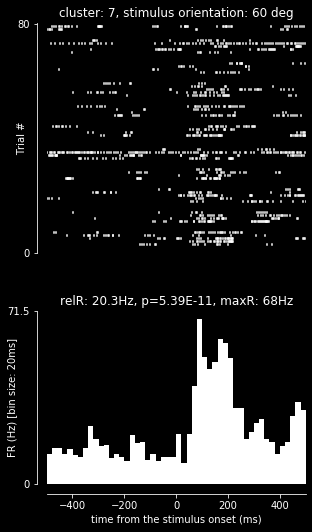

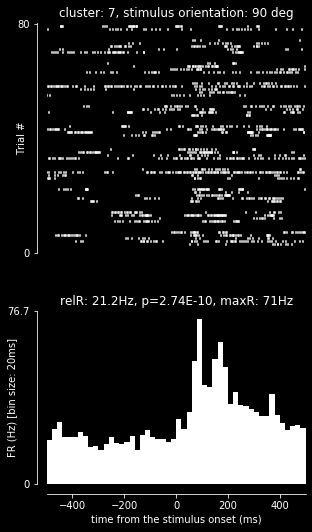

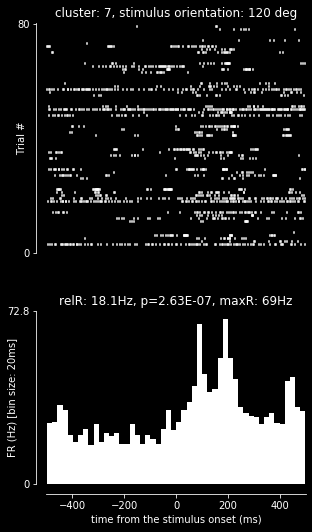

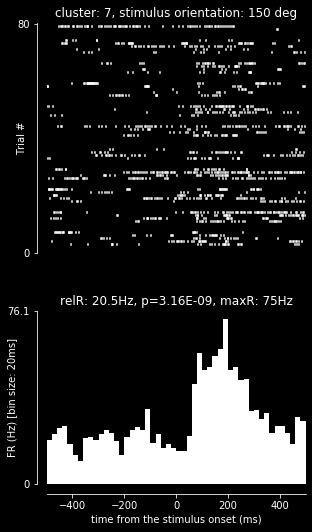

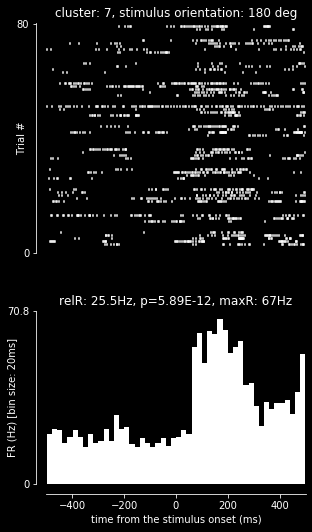

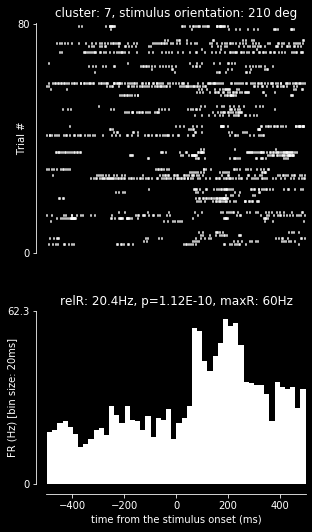

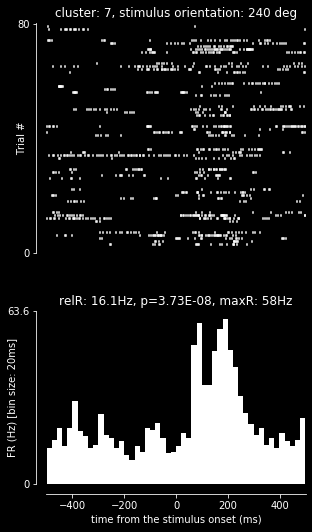

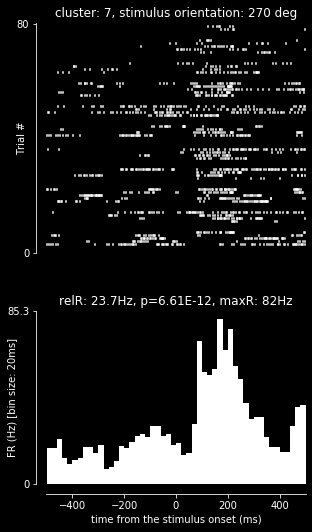

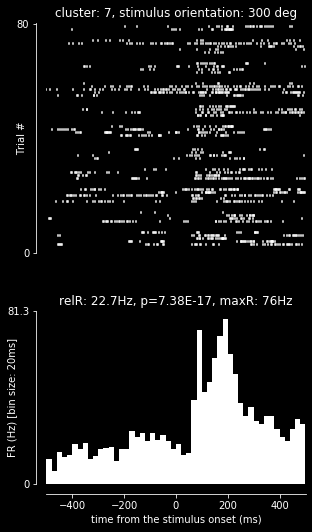

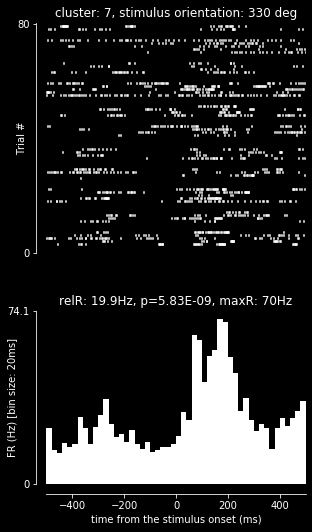

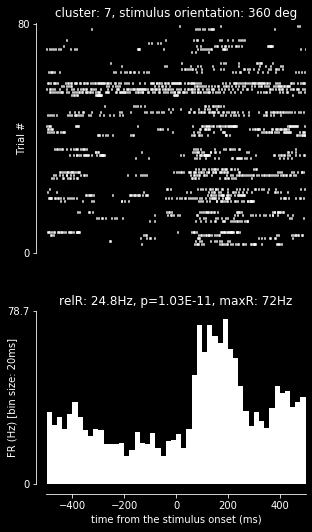

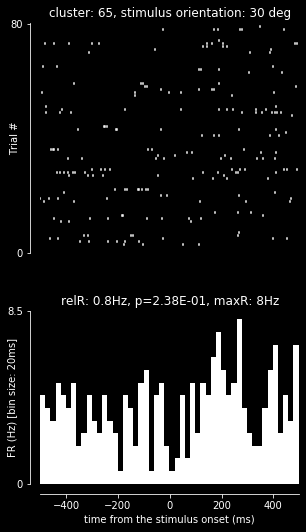

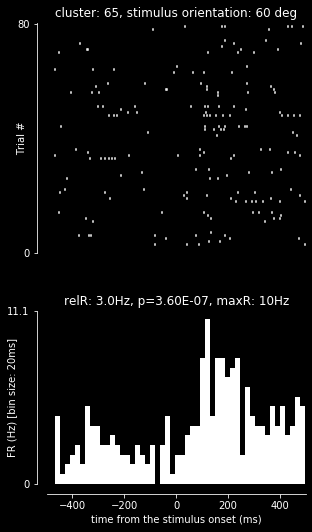

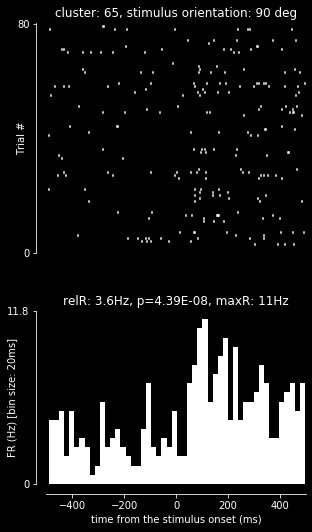

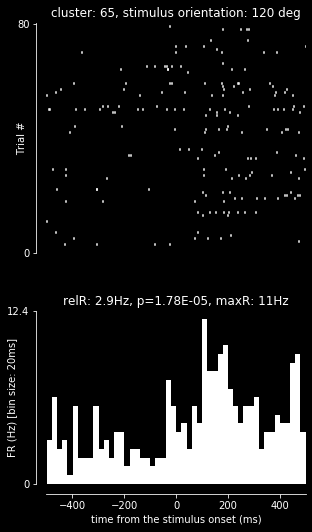

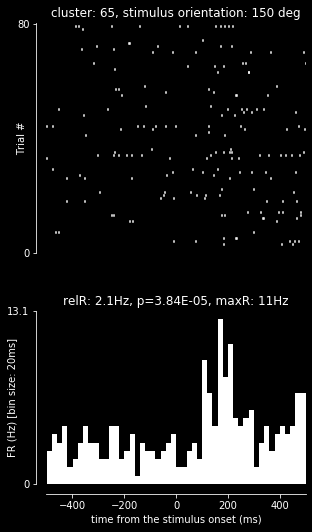

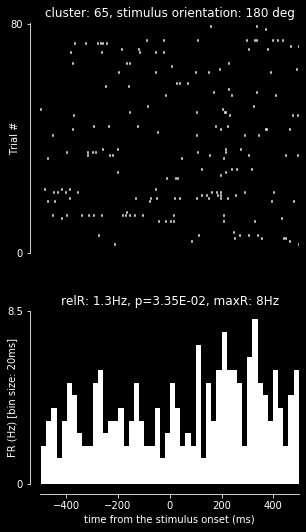

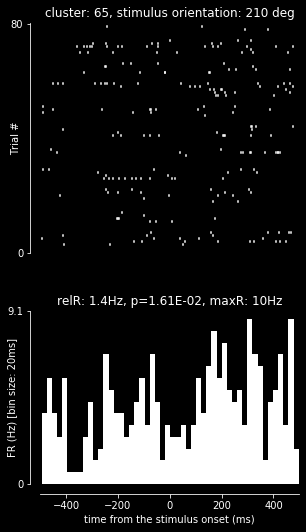

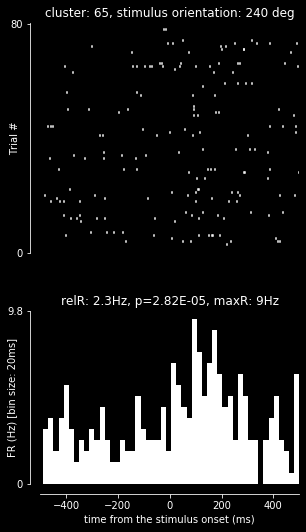

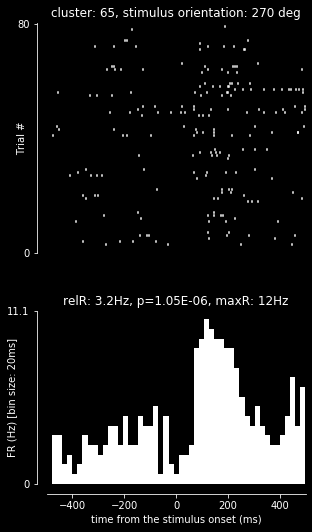

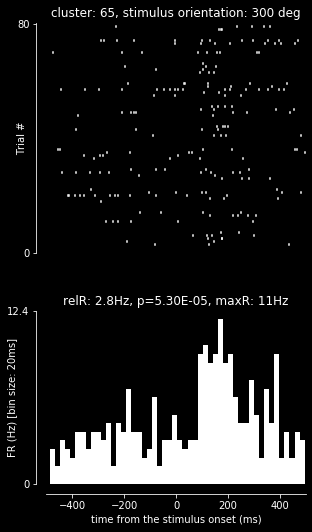

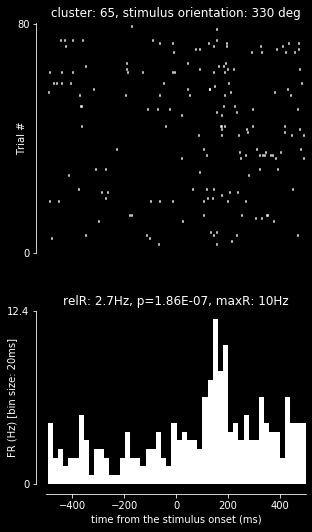

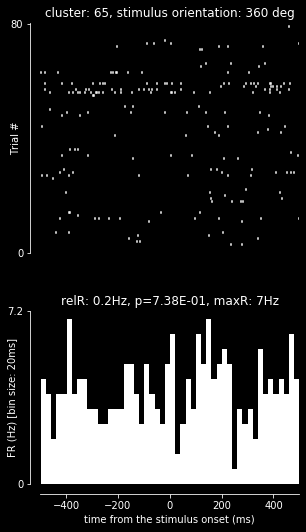

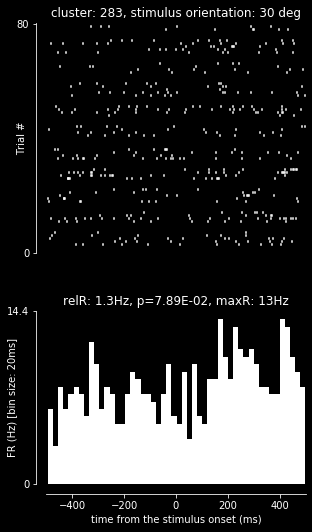

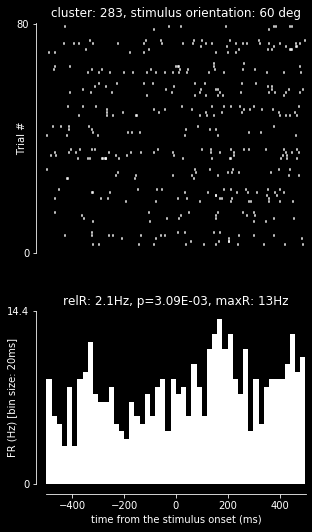

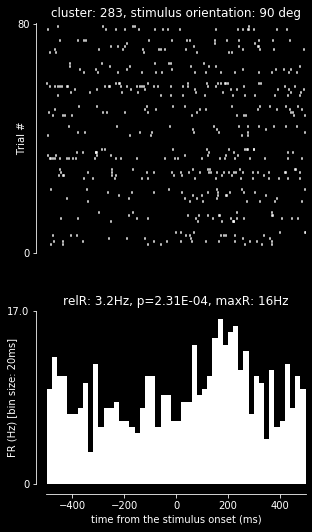

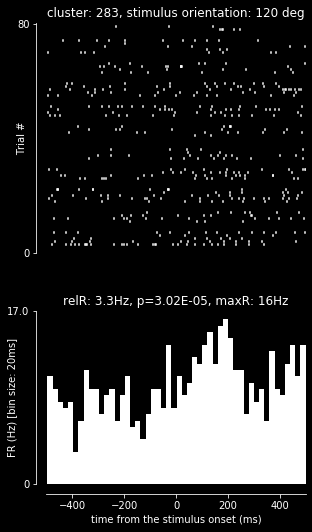

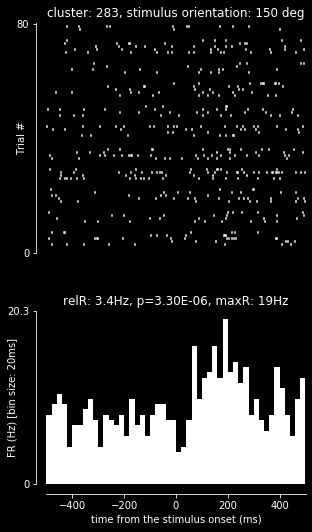

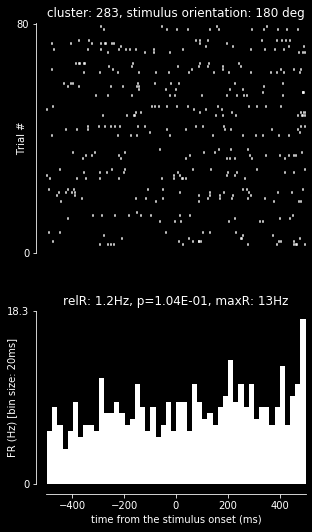

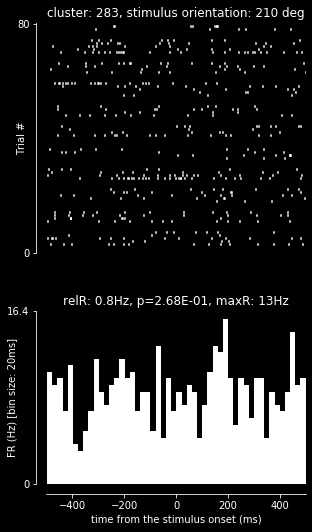

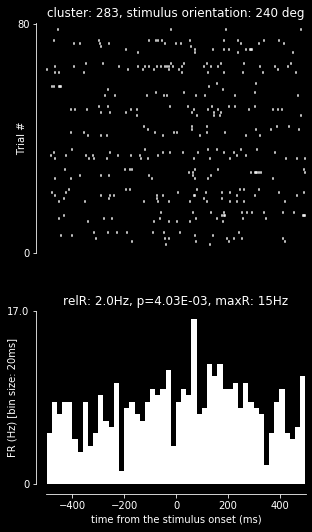

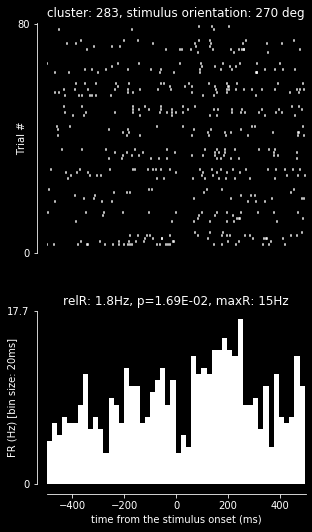

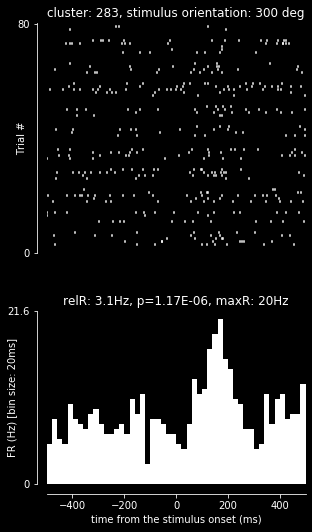

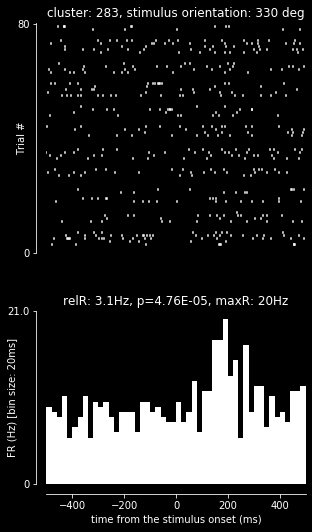

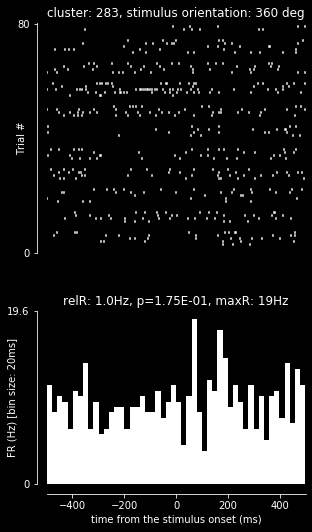

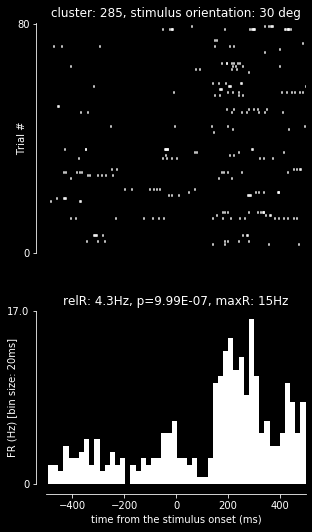

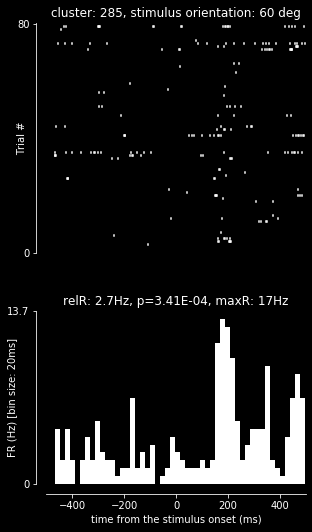

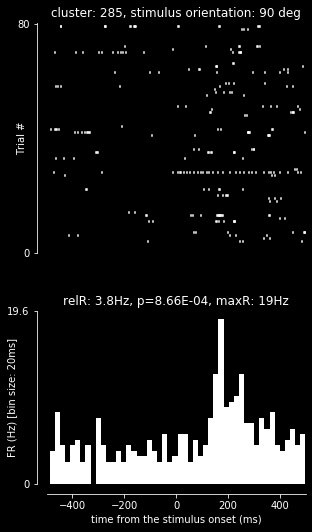

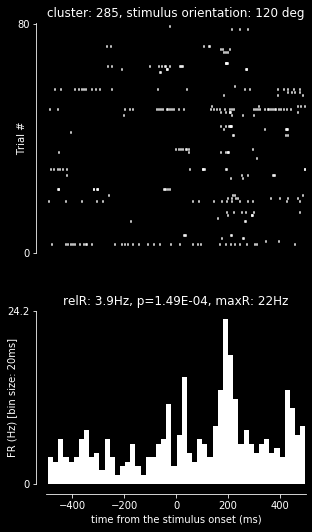

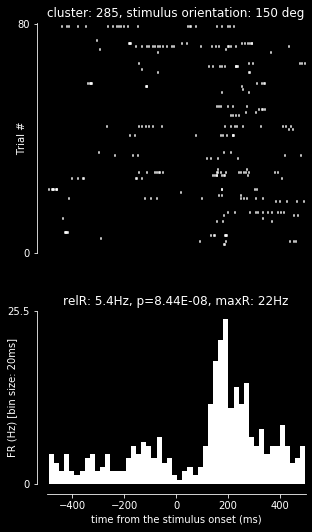

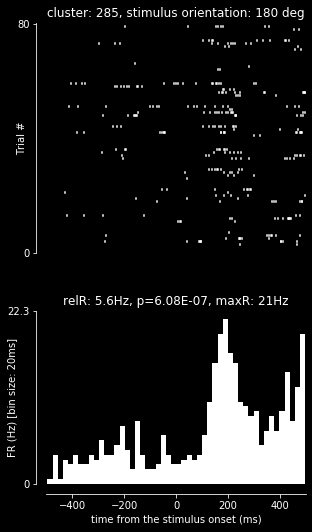

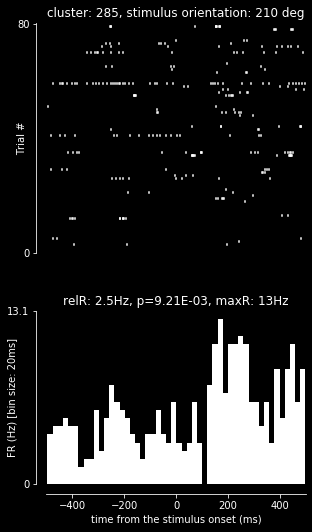

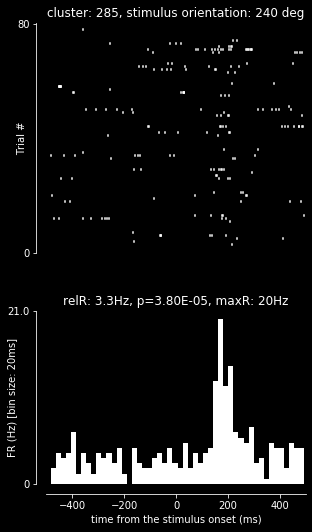

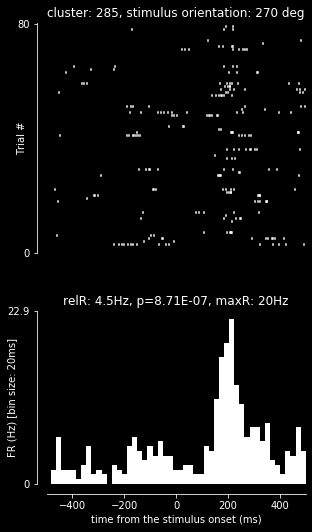

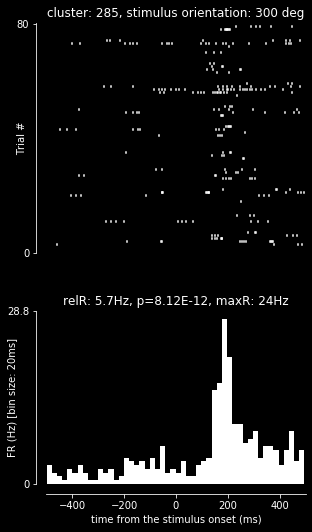

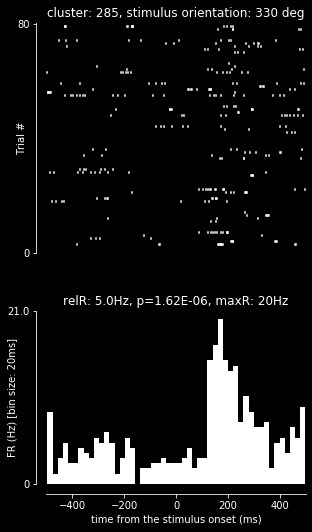

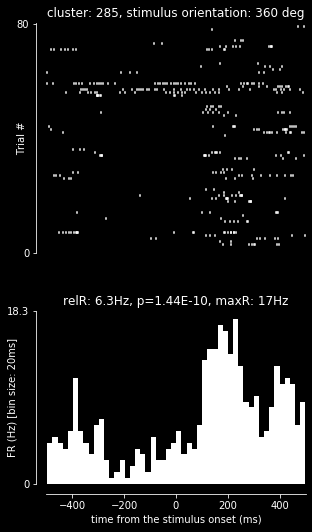

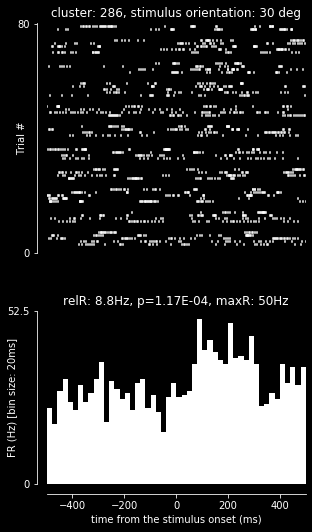

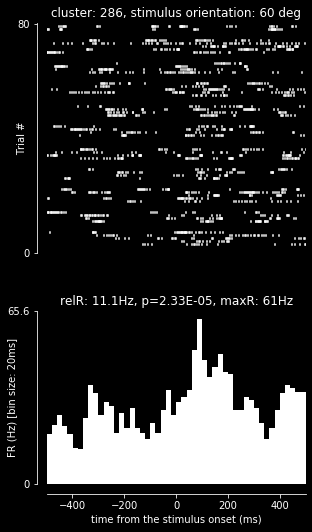

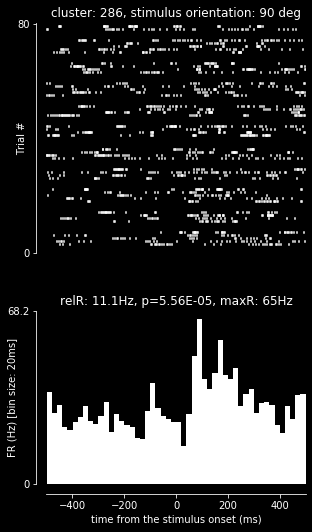

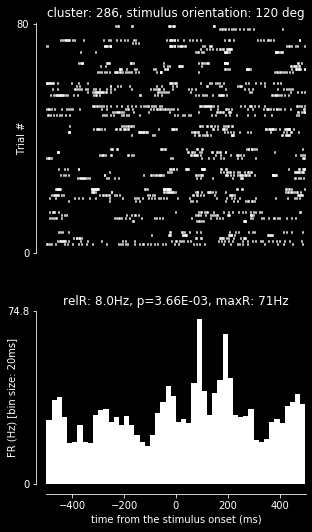

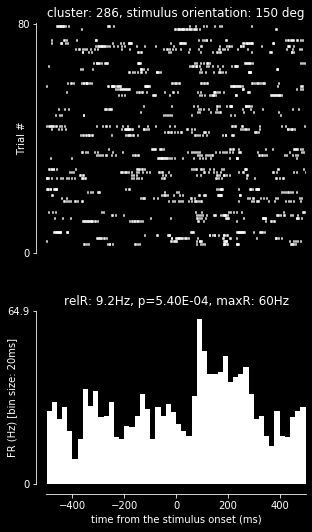

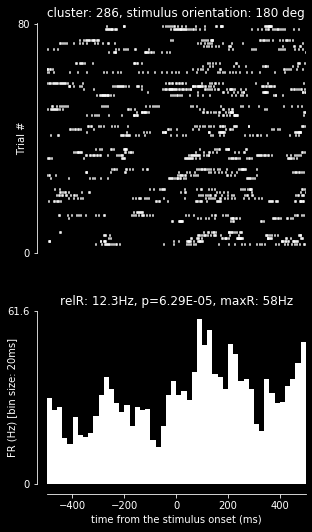

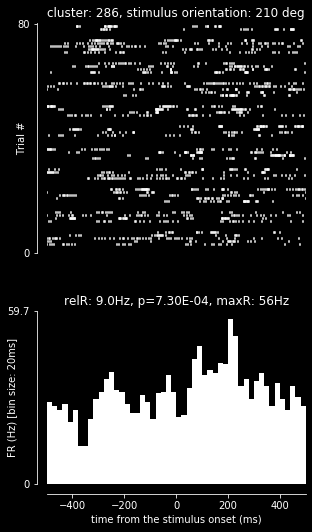

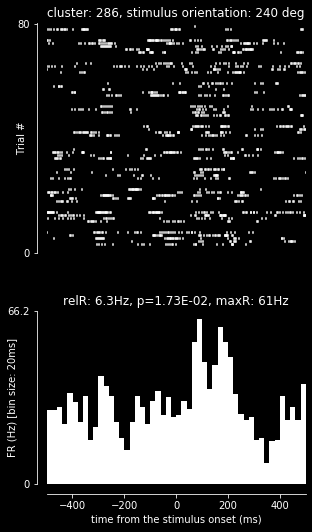

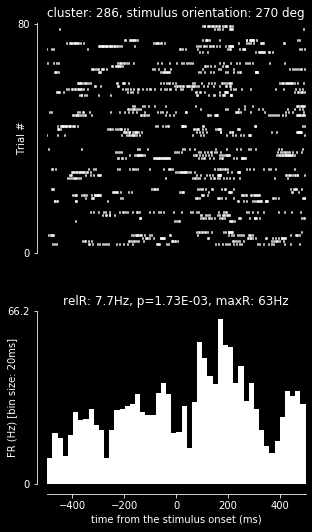

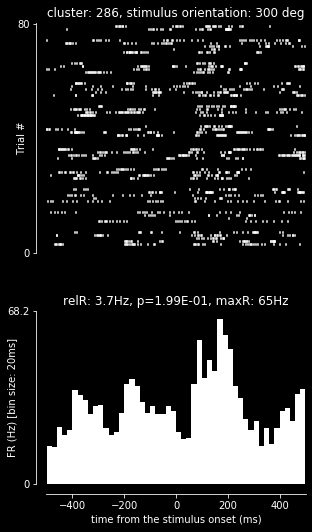

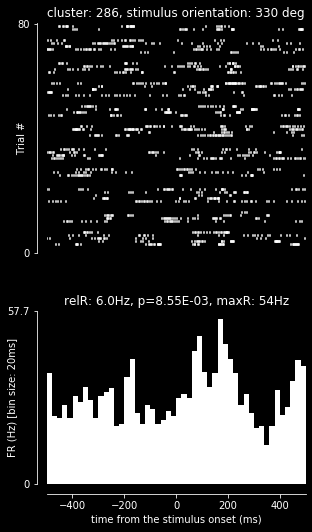

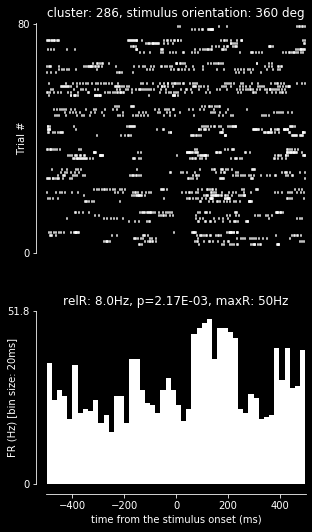

In [16]:
allClustersResponsiveness = []
allClustersBaselineCorrectedResponse = []
allClustersMaxFR_response = []

for clusterNo in spikeClustersToPlot:
    responsiveness, clusterBaselineCorrectedResponse, clusterMaxResponse, clusterResponsivenessPvals = \
        neuronVisualResponse(clusterNo,spikeTime,spikeClusters,stimID,stimOnsetSample,darkMode = darkMode);
    
    allClustersResponsiveness.append(responsiveness)
    allClustersBaselineCorrectedResponse.append(clusterBaselineCorrectedResponse)
    allClustersMaxFR_response.append(clusterMaxResponse)

### Tuning curve and Orienation Selectivity Index

In [45]:
allOSI = []
# allOSI_max = []
for clusterNo in range(len(spikeClustersToPlot)):
    if allClustersResponsiveness[clusterNo]:
        allOSI.append(tuningCurveAndOSI(allClustersBaselineCorrectedResponse[clusterNo]));
#     allOSI_max.append(tuningCurveAndOSI(allClustersMaxFR_response[clusterNo]))

TypeError: tuningCurveAndOSI() missing 1 required positional argument: 'clusterNo'

### Baseline and Evoked comparison between alert and non alert trials

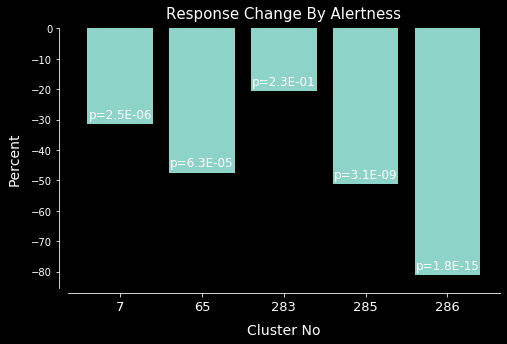

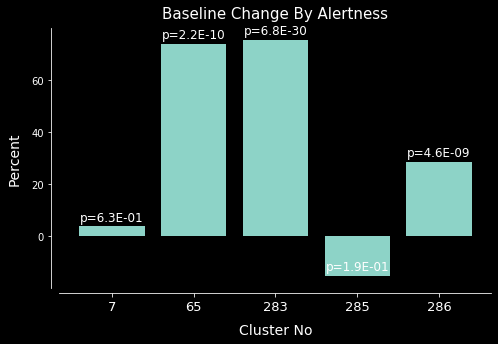

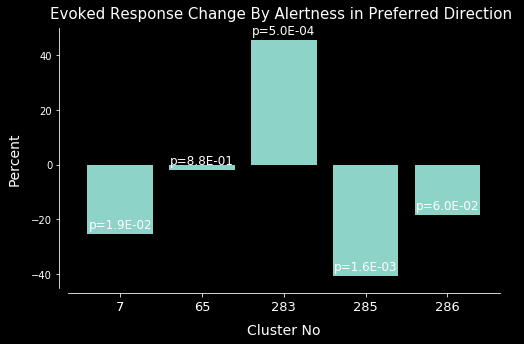

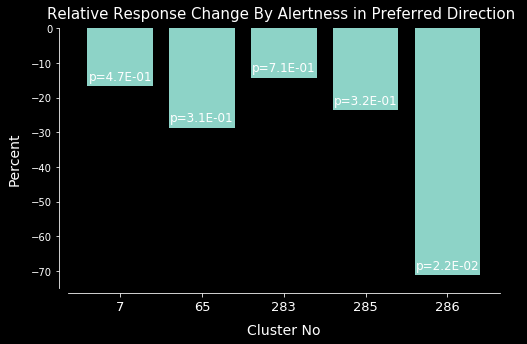

In [35]:
# Extracting the high and low-arousal level trials
lowArousalStimTrials, highArousalStimTrials = \
            extractLowAndHighArousalTrials(framesStartSample, pupilSmoothArea, stimOnsetSample,\
                timeWindowBeforeStimStart = 500,\
                timeWindowAfterStimStart = 0)

allTrialsRelResponse, allTrialsBaseline, allTrialsEvokedResponse\
                    = allTrialsResponses(spikeClusters, spikeTime, stimOnsetSample,\
                        spikeClustersToPlot[np.where(allClustersResponsiveness)])

# response change by alertness

allClustersNormalizedArousalResponseChange, allPvalArousalResponseDiff = responseChangeByAlertness(\
            spikeClustersToPlot[np.where(allClustersResponsiveness)],\
            allTrialsRelResponse,highArousalStimTrials,lowArousalStimTrials)

# Basline change by alertness
allClustersNormalizedArousalBaselineChange, allPvalaselineChange = responseChangeByAlertness(\
            spikeClustersToPlot[np.where(allClustersResponsiveness)],\
            allTrialsBaseline,highArousalStimTrials,lowArousalStimTrials,\
            figTitle = 'Baseline Change By Alertness')

# Evoked response change in the preferred stim by alertness
evokedResponseChangeByArousa, pvalEvokedResponseChange = \
bestOrienationResponseChangeByAlertness(spikeClustersToPlot,allTrialsEvokedResponse,\
    highArousalStimTrials,lowArousalStimTrials,allClustersBaselineCorrectedResponse,\
    allClustersResponsiveness,stimID,figTitle = 'Evoked Response Change By Alertness in Preferred Direction ');

# relative response change in the preferred stim by alertness
bestDirectionRelResponseChangeByArousal, pvalBestDirectionResponseChange = \
bestOrienationResponseChangeByAlertness(spikeClustersToPlot,allTrialsRelResponse,\
    highArousalStimTrials,lowArousalStimTrials,allClustersBaselineCorrectedResponse,\
    allClustersResponsiveness,stimID,figTitle = 'Relative Response Change By Alertness in Preferred Direction ');

### Tuning Curve and OSI between Alert and non Alert

Text(0.5, 1.0, 'OSI change with alertness')

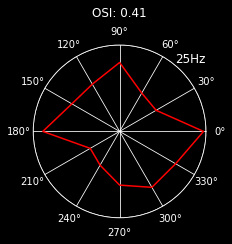

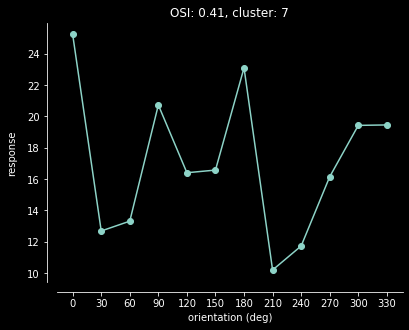

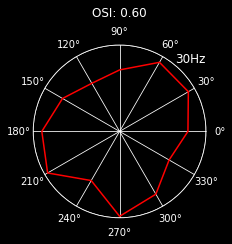

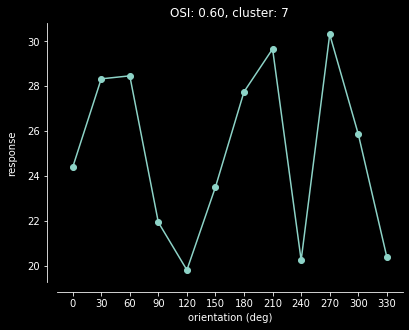

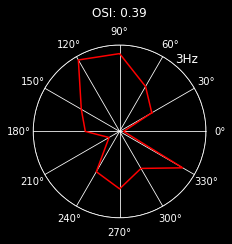

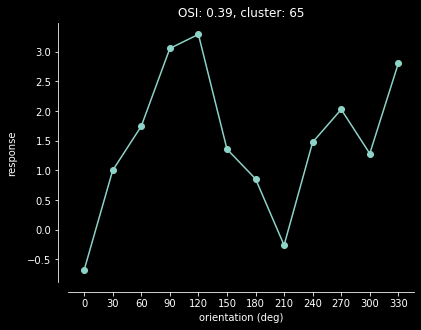

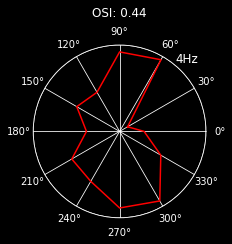

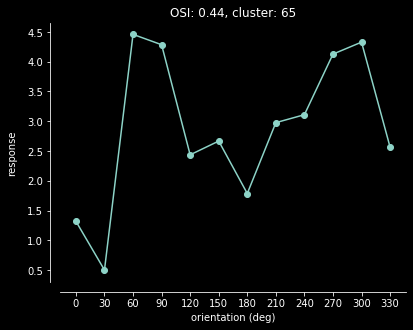

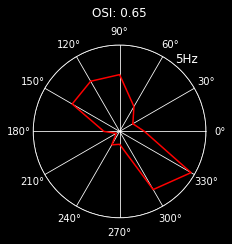

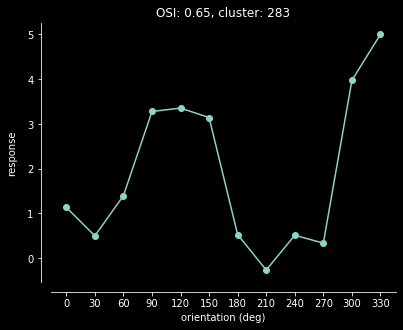

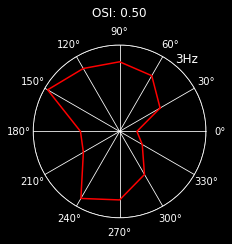

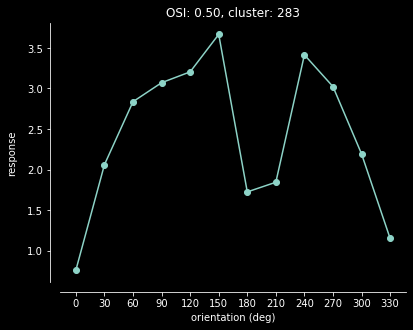

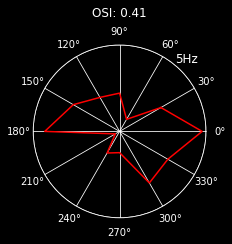

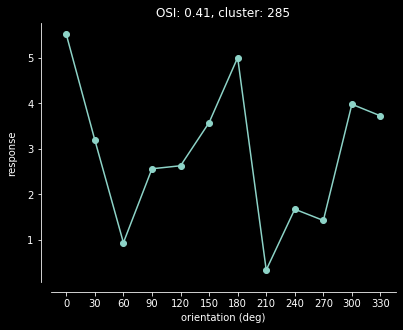

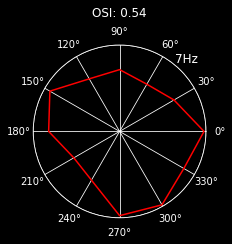

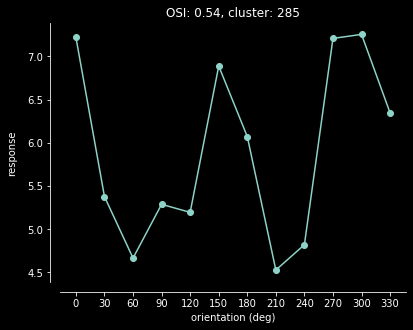

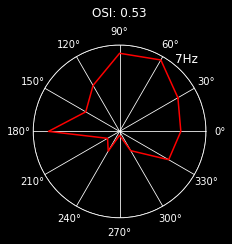

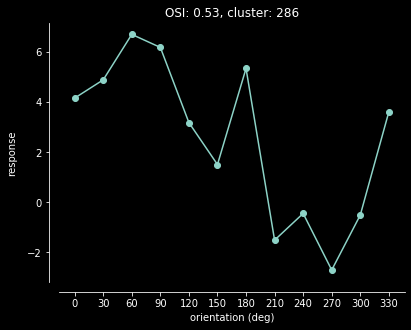

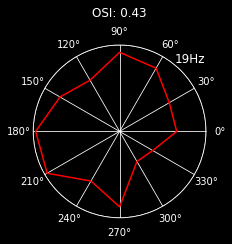

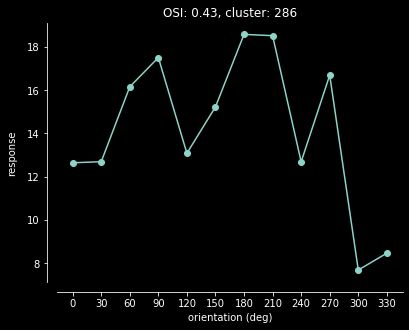

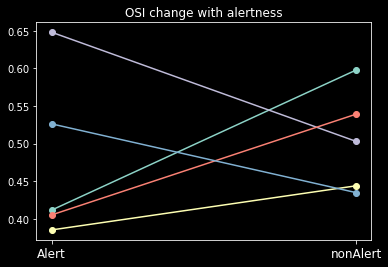

In [39]:
allClustersAlertMeanOrientationResponse = []
allClustersNonAlertMeanOrientationResponse = []
OSI_Alert = []
OSI_nonAlert = []
for clusterCounter in range(len(np.where(allClustersResponsiveness)[0])):

    alertMeanOrientationResponse = []
    nonAlertMeanOrientationResponse = []
    for orientationCounter in np.unique(stimID):

        alertResponseCluster = allTrialsRelResponse[clusterCounter]\
                            [np.intersect1d(np.where(stimID==orientationCounter)[0], highArousalStimTrials)]

        nonAlertResponseCluster = allTrialsRelResponse[clusterCounter]\
                            [np.intersect1d(np.where(stimID==orientationCounter)[0], lowArousalStimTrials)]

        alertMeanOrientationResponse.append(np.mean(alertResponseCluster))
        nonAlertMeanOrientationResponse.append(np.mean(nonAlertResponseCluster))
        
    allClustersAlertMeanOrientationResponse.append(alertMeanOrientationResponse)
    allClustersNonAlertMeanOrientationResponse.append(nonAlertMeanOrientationResponse)
#         print(stats.ttest_ind(alertResponseCluster,nonAlertResponseCluster)[1],\
#              np.mean(alertResponseCluster),np.mean(nonAlertResponseCluster))
    
    OSI_Alert.append(tuningCurveAndOSI(alertMeanOrientationResponse,spikeClustersToPlot[clusterCounter]))
    OSI_nonAlert.append(tuningCurveAndOSI(nonAlertMeanOrientationResponse,\
                                          spikeClustersToPlot[clusterCounter]))
    
plt.figure()
plt.plot([1,2],np.array([OSI_Alert,OSI_nonAlert]),'o-')
plt.xticks([1,2],(['Alert','nonAlert']),fontsize=12)
plt.title('OSI change with alertness')

### noise correlation between alert and non-alert trials

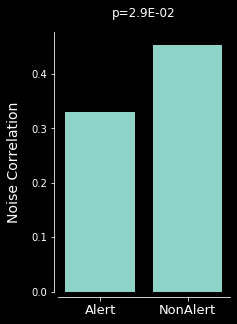

In [20]:
noiseCorrAlert, noiseCorrNonAlert, pval = noiseCorrBetweenAlertAndNonAlertTrials\
        (allTrialsRelResponse,highArousalStimTrials,lowArousalStimTrials)

# print(stats.ttest_ind(noiseCorrAlert,noiseCorrNonAlert)[1],np.mean(noiseCorrAlert)\
#               ,np.mean(noiseCorrNonAlert))

### power Spectrum in L5

#### estimated L5 channel

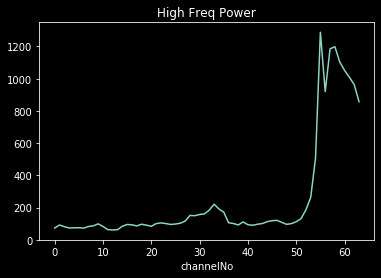

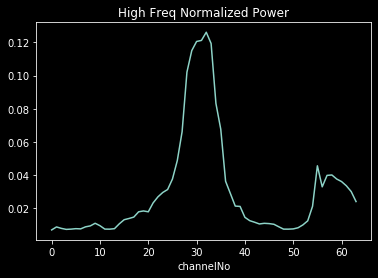

In [21]:
dataFileAddReorderRereferenced = dataFileBaseFolder + '/' + 'amplifierReorderRereferencedMedian.dat'
L5channelNo, allChannelsNormHighFreqPower,\
        allChannelsHighFreqPower = estimatedL5chnnael(dataFileAddReorderRereferenced,\
                                                      firstBeforeStimTagSampleNo)
L4channelNo = L5channelNo - 8
L23channelNo = L5channelNo - 15

#### reading low pass filtered data file

In [41]:
dataFile = open(dataFileBaseFolder + '/' + 'amplifierReorderRereferencedLowPass.dat' , 'rb')
dataArray = np.fromfile(dataFile,dtype='int16')
dataFile.close()

del dataFile

dataMatrixReorderLowPassFiltered = np.reshape(dataArray, (int(dataArray.shape[0]/channelsNo), channelsNo)).T

del dataArray

#### power spectrum on the channel estimated to be in L5 during spontaneous activity

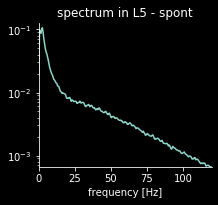

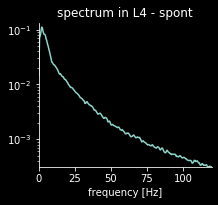

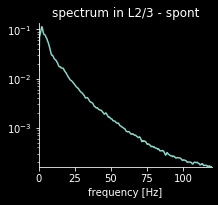

In [42]:
spontEndTime = firstBeforeStimTagSampleNo/fs # in seconds
reducedSamplingRate = 2e3
df = 0.5

inputSignalToFreqAnalysis = dataMatrixReorderLowPassFiltered[L5channelNo]\
                                 [:int(spontEndTime*reducedSamplingRate)]*0.195

f_powerSpectrum, powerSpectrumL5, estimatedTotalPower = \
            powerSpectrumSingleChannel(inputSignalToFreqAnalysis,reducedSamplingRate\
                                          ,figToShow = True,\
maxFreqToShow = 120, freqRes = df, Normalized = 1, figTitle = 'spectrum in L5 - spont' )

inputSignalToFreqAnalysis = dataMatrixReorderLowPassFiltered[L4channelNo]\
                                 [:int(spontEndTime*reducedSamplingRate)]*0.195

f, powerSpectrumL4, estimatedTotalPower = \
            powerSpectrumSingleChannel(inputSignalToFreqAnalysis,reducedSamplingRate\
                                          ,figToShow = True,\
maxFreqToShow = 120, freqRes = df, Normalized = 1, figTitle = 'spectrum in L4 - spont' )

inputSignalToFreqAnalysis = dataMatrixReorderLowPassFiltered[L23channelNo]\
                                 [:int(spontEndTime*reducedSamplingRate)]*0.195

f, powerSpectrumL23, estimatedTotalPower = \
            powerSpectrumSingleChannel(inputSignalToFreqAnalysis,reducedSamplingRate\
                                          ,figToShow = True,\
maxFreqToShow = 120, freqRes = df, Normalized = 1, figTitle = 'spectrum in L2/3 - spont' )

### power spectrum between alert and non alert periods

#### detecting the consecutive periods of alert and non alert

In [43]:
alertChoosedEpochsStarts, alertChoosedEpochsEnds, nonAlertChoosedEpochsStarts, \
    nonAlertChoosedEpochsEnds = exctractAlertAndNonAlertPeriods(pupilSmoothArea,framesStartSample,\
                0,spontEndTime,minimumConsistentStateDur = 10)

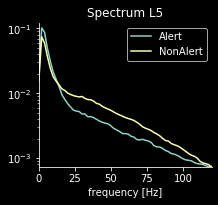

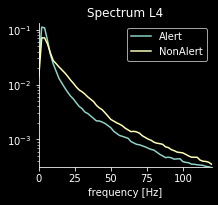

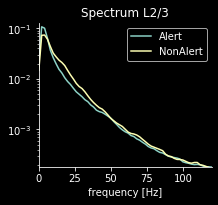

In [44]:
inputSignalToFreqAnalysis = dataMatrixReorderLowPassFiltered[L5channelNo]
f, alertSpectrumL5, nonAlertSpectrumL5 = spectrumCompareAlertNonAlert(inputSignalToFreqAnalysis,\
        alertChoosedEpochsStarts, alertChoosedEpochsEnds,\
     nonAlertChoosedEpochsStarts, nonAlertChoosedEpochsEnds, framesStartSample,\
     timeToExclude = 2, df = 2, figTitle = 'Spectrum L5')

inputSignalToFreqAnalysis = dataMatrixReorderLowPassFiltered[L4channelNo]
f, alertSpectrumL4, nonAlertSpectrumL4 = spectrumCompareAlertNonAlert(inputSignalToFreqAnalysis,\
        alertChoosedEpochsStarts, alertChoosedEpochsEnds,\
     nonAlertChoosedEpochsStarts, nonAlertChoosedEpochsEnds, framesStartSample,\
     timeToExclude = 2, df = 2, figTitle = 'Spectrum L4')

inputSignalToFreqAnalysis = dataMatrixReorderLowPassFiltered[L23channelNo]
f, alertSpectrumL23, nonAlertSpectrumL23 = spectrumCompareAlertNonAlert(inputSignalToFreqAnalysis,\
        alertChoosedEpochsStarts, alertChoosedEpochsEnds,\
     nonAlertChoosedEpochsStarts, nonAlertChoosedEpochsEnds, framesStartSample,\
     timeToExclude = 2, df = 2, figTitle = 'Spectrum L2/3')



### variables to save

In [31]:
# 0 waveshapes
# 1 spikeWidth
# 2 spont FRs
# 3 clusterChannel
# 4 spike-triggered pupil area
# 5 responsiveness 
# 6 baselineCorrectedResponse
# 7 OSI
# 8 Alert OSI
# 9 nonAlert OSI
# 10 relative response Change By Arousal
# 11 basline change by arousal
# 12 evoked-response change by arousal
# 13 best direction response change by arousal
# 14 noise correlation alert
# 15 noise correlation non-alert
# 16 normalized high freq power on all channels
# 17 high freq power on all channels
# 18 power sepctrum L5
# 19 power spectrum L4
# 20 power spectrum L23
# 21 frequency vector
# 22 power spectrum alert L5
# 23 power spectrum non alert L5
# 24 power spectrum alert L4
# 25 power spectrum non alert L4
# 26 power spectrum alert L23
# 27 power spectrum non alert L23

animalName = 'CW_191110_072941'

savingAdd = 'Y://Ehsan-temp//Claire-Ehsan_Share//DataToMerge//'

variableToExportToMerge = [spikeShapesFiltered, spikeWidthAll, spontFRs, clusterChannel,\
        allSpikeTriggeredPupil, allClustersResponsiveness, \
        allClustersBaselineCorrectedResponse, allOSI, OSI_Alert, OSI_nonAlert,\
        allClustersNormalizedArousalResponseChange, allClustersNormalizedArousalBaselineChange,\
        evokedResponseChangeByArousa, bestDirectionRelResponseChangeByArousal, noiseCorrAlert, \
        noiseCorrNonAlert, allChannelsNormHighFreqPower, allChannelsHighFreqPower, powerSpectrumL5,\
        powerSpectrumL4, powerSpectrumL23, f_powerSpectrum, alertSpectrumL5, nonAlertSpectrumL5,\
        alertSpectrumL4, nonAlertSpectrumL4, alertSpectrumL23, nonAlertSpectrumL23]

import pickle
pickle.dump(variableToExportToMerge, open(savingAdd+animalName+'.pkl', "wb" ) )